
## Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torch==1.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
  # !wget https://www.python.org/ftp/python/3.8.0/Python-3.8.0.tgz
  # !tar xvfz Python-3.8.0.tgz
  # !Python-3.8.0/configure
  # !make
  # !sudo make install

In [3]:
import random
import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
!python --version
print(torch.__version__)

Python 3.7.15
1.9.0+cu102


In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Data Load

In [6]:
cd drive/MyDrive/Colab Notebooks/따릉이

/content/drive/MyDrive/Colab Notebooks/따릉이


## Data Visualization

In [7]:
train = pd.read_csv('./train.csv')

In [8]:
def get_view_df(df, target):
    viewd = df[['일시', target]]
    viewd = viewd.reset_index(drop=True)
    viewd = viewd.reset_index()
    print(target)
    sns.set(rc = {'figure.figsize':(30,8)})
    sns.lineplot(x='index', y=target, data=viewd)
    plt.show()

광진구


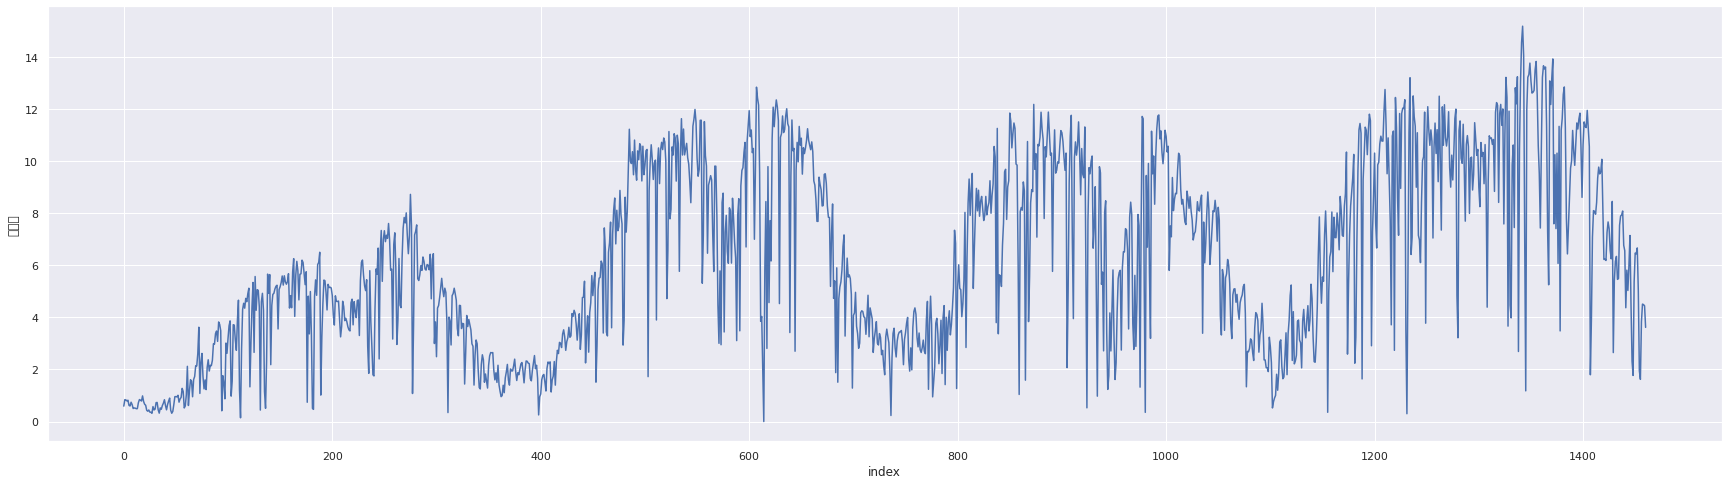

동대문구


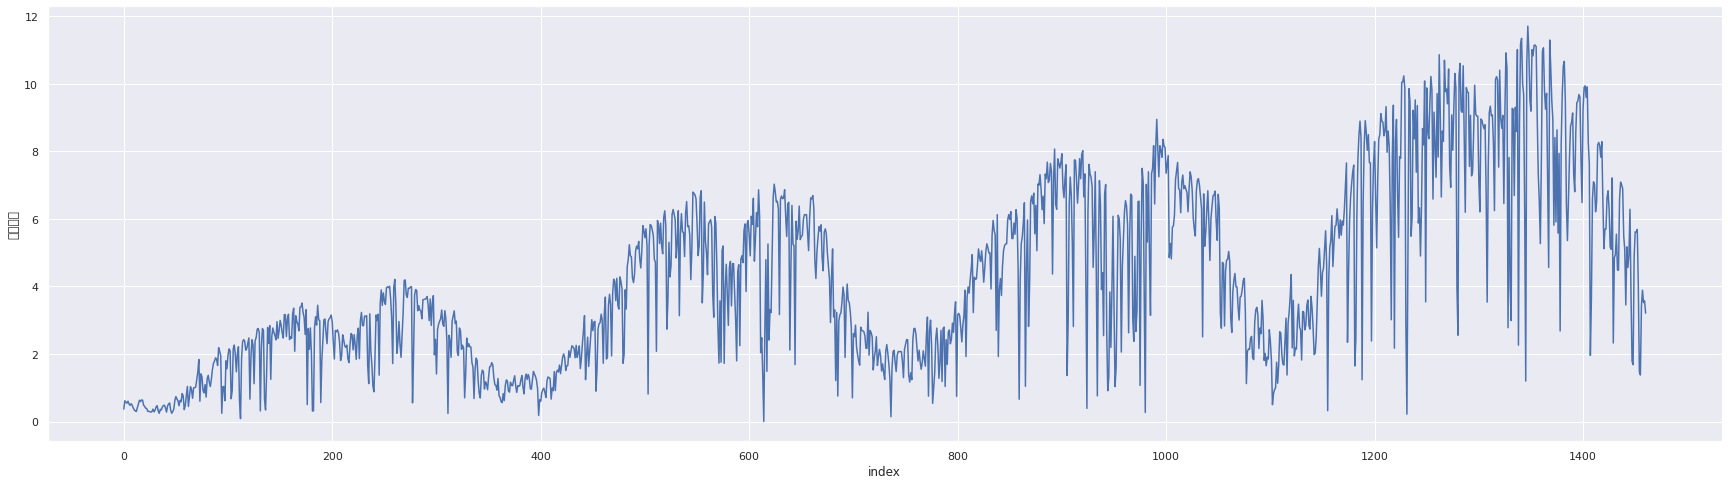

성동구


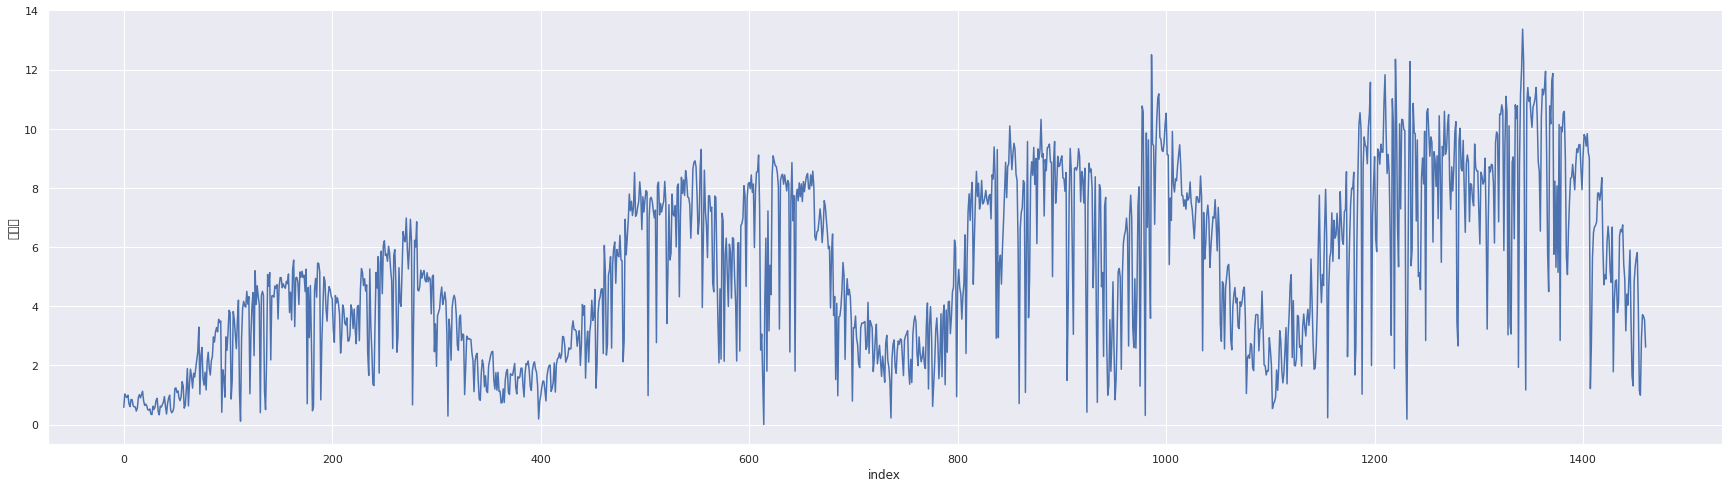

중랑구


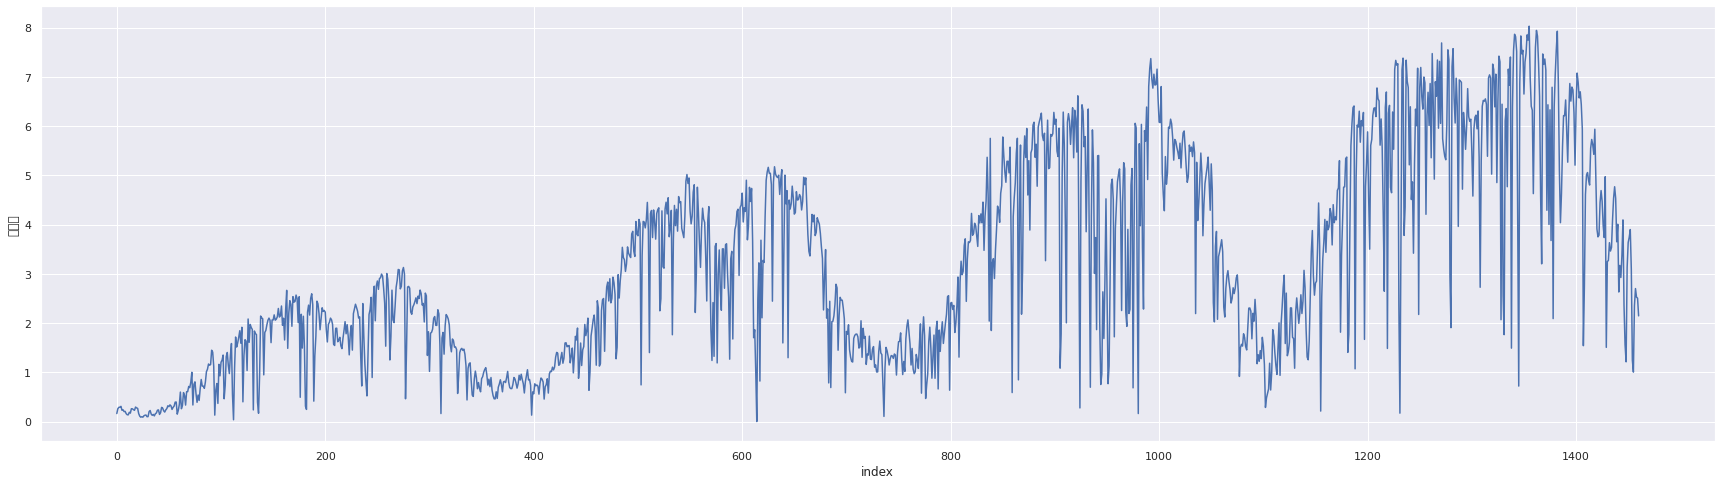

In [9]:
get_view_df(train, '광진구')
get_view_df(train, '동대문구')
get_view_df(train, '성동구')
get_view_df(train, '중랑구')

## Hyperparameter Setting

In [450]:
CFG = {
    'X_RANGE':7, # 예측하려는 시점을 X_RANGE 만큼의 이전 일자의 데이터로부터 예측 및 학습
    'EPOCHS':50,
    'LEARNING_RATE':1e-2,
    'BATCH_SIZE':128,
    'SEED':42 #0
}

## Fixed RandomSeed

In [451]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed 고정

## Train / Validation Split

### 계절성 제거 후 추세성, 불규칙성, 순환성을 새로운 피처로 활용

In [452]:
train = pd.read_csv('./train.csv')

In [453]:
from datetime import datetime

train['일시'] = train.일시.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))
train.set_index('일시',inplace=True)

In [454]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

def func_diff(location,lamb):
    # 계절성 제거
    result = seasonal_decompose(train['{}'.format(location)], model='additive')
    result = result.observed
    
    # 추세 변동요인 추출 - trend
    cycle, trend = sm.tsa.filters.hpfilter(result,lamb)
    data_불규칙 = pd.DataFrame(cycle)

    # 불규칙 변동요인 제거한 순환변동요인 추출 - cycle2
    unrule, cycle2 = sm.tsa.filters.hpfilter(data_불규칙,lamb)

    # 표준화
    cycle2 = (cycle2-np.mean(cycle2))/np.std(cycle2)

    train['cycle_{}'.format(location)] = cycle2
    train['unrule_{}'.format(location)] = unrule
    train['trend_{}'.format(location)] = trend

In [455]:
func_diff('광진구', 6000) #14400별로, 6000 낫벳, 
func_diff('동대문구', 6000)
func_diff('성동구', 6000)
func_diff('중랑구', 6000)

In [456]:
train

,광진구,동대문구,성동구,중랑구,cycle_광진구,unrule_광진구,trend_광진구,cycle_동대문구,unrule_동대문구,trend_동대문구,cycle_성동구,unrule_성동구,trend_성동구,cycle_중랑구,unrule_중랑구,trend_중랑구
일시,,,,,,,,,,,,,,,,
2018-01-01,0.592,0.368,0.580,0.162,0.116824,-0.156410,0.734238,0.109717,-0.169174,0.529312,0.136639,-0.277299,0.843289,0.140730,-0.092770,0.246814
2018-01-02,0.840,0.614,1.034,0.260,0.118891,0.100249,0.725328,0.115987,0.082535,0.523153,0.141457,0.185809,0.833688,0.139241,0.009269,0.242859
2018-01-03,0.828,0.576,0.952,0.288,0.120744,0.096958,0.716394,0.121863,0.050299,0.516968,0.145824,0.113006,0.824043,0.137479,0.041337,0.238890
2018-01-04,0.792,0.542,0.914,0.292,0.122304,0.069731,0.707432,0.127144,0.022144,0.510745,0.149591,0.084319,0.814343,0.135198,0.049460,0.234896
2018-01-05,0.818,0.602,0.994,0.308,0.123629,0.104547,0.698455,0.131746,0.088079,0.504480,0.152794,0.173734,0.804600,0.132272,0.069648,0.230873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.830,3.416,2.908,2.350,-0.131387,-0.275964,4.121903,-0.325621,-0.052355,3.491689,-0.087054,-0.370124,3.287049,0.024399,-0.062804,2.411424
2021-12-28,4.510,3.890,3.714,2.700,-0.155771,0.511998,4.016898,-0.380915,0.518608,3.398689,-0.136566,0.527721,3.200281,0.022761,0.347245,2.351468
2021-12-29,4.490,3.524,3.660,2.524,-0.177763,0.599405,3.912159,-0.432899,0.249132,3.305890,-0.184865,0.565344,3.113611,0.023170,0.231061,2.291629


In [457]:
train = train.reset_index()
train['일시'] = train['일시'].astype(str)

cycle_광진구


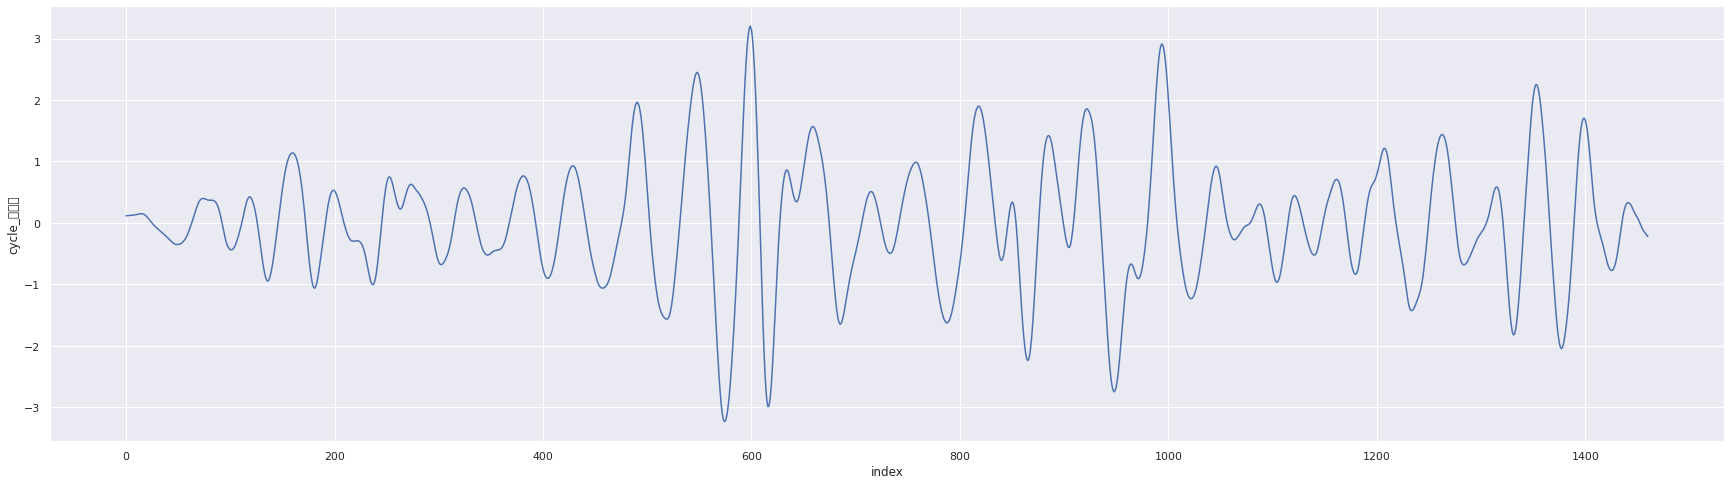

unrule_광진구


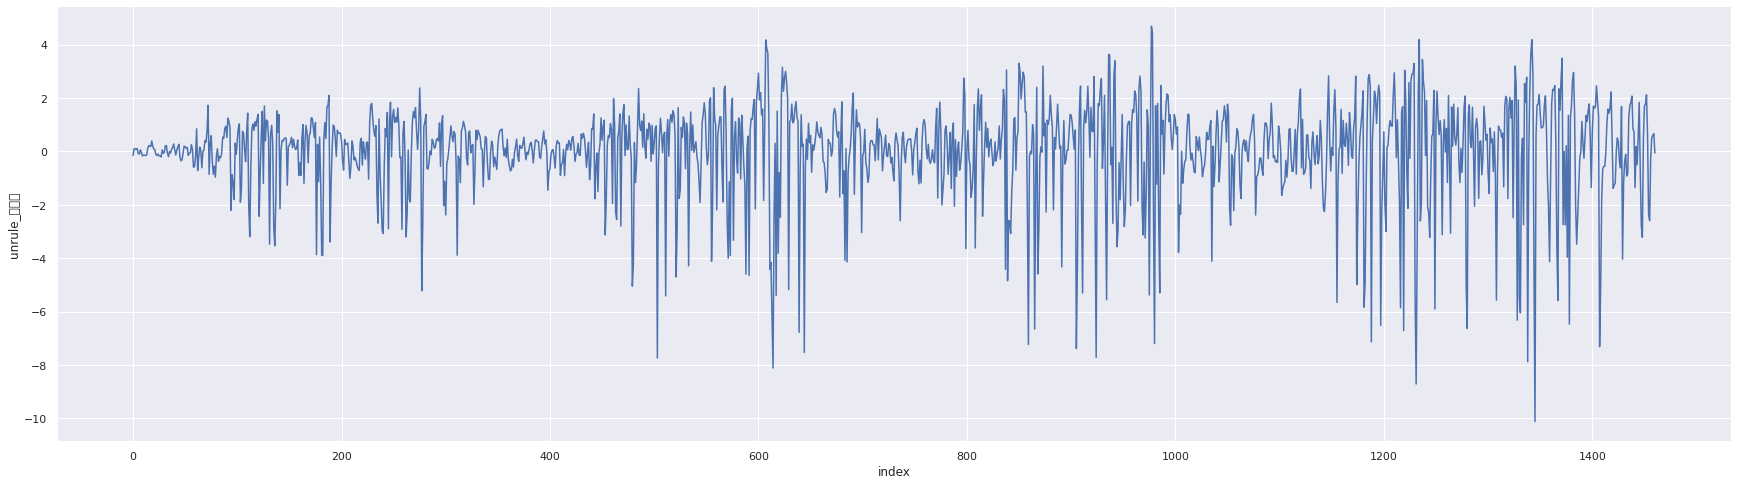

trend_광진구


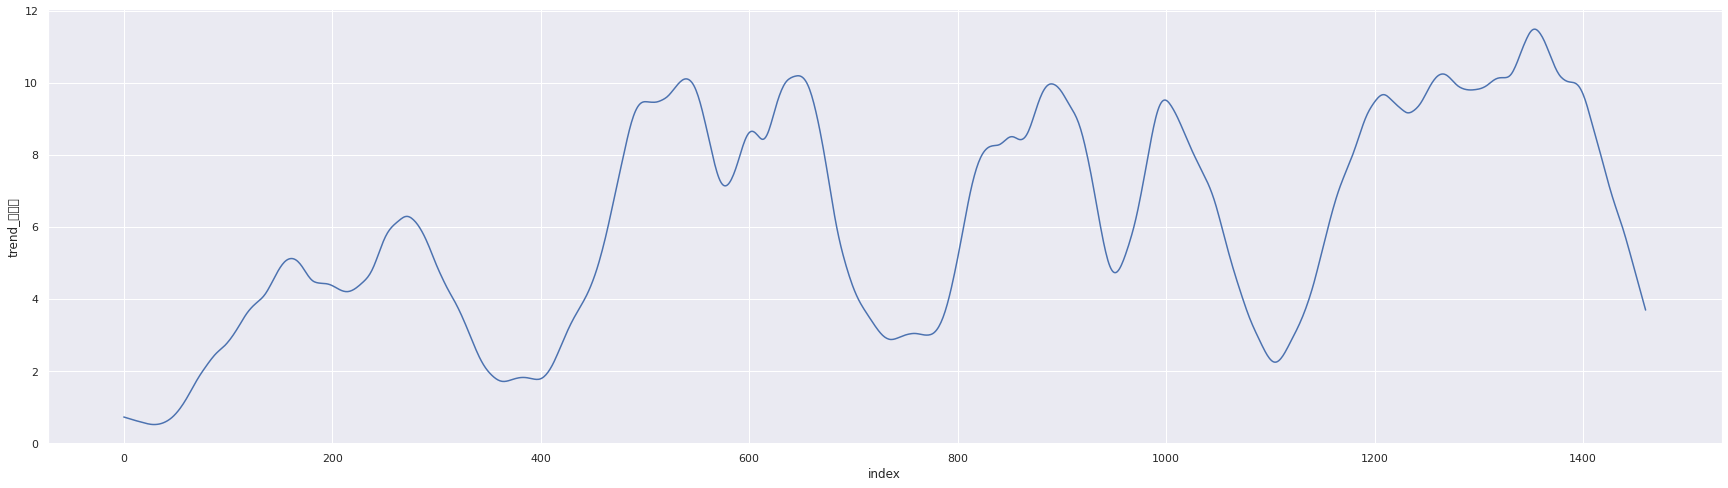

광진구


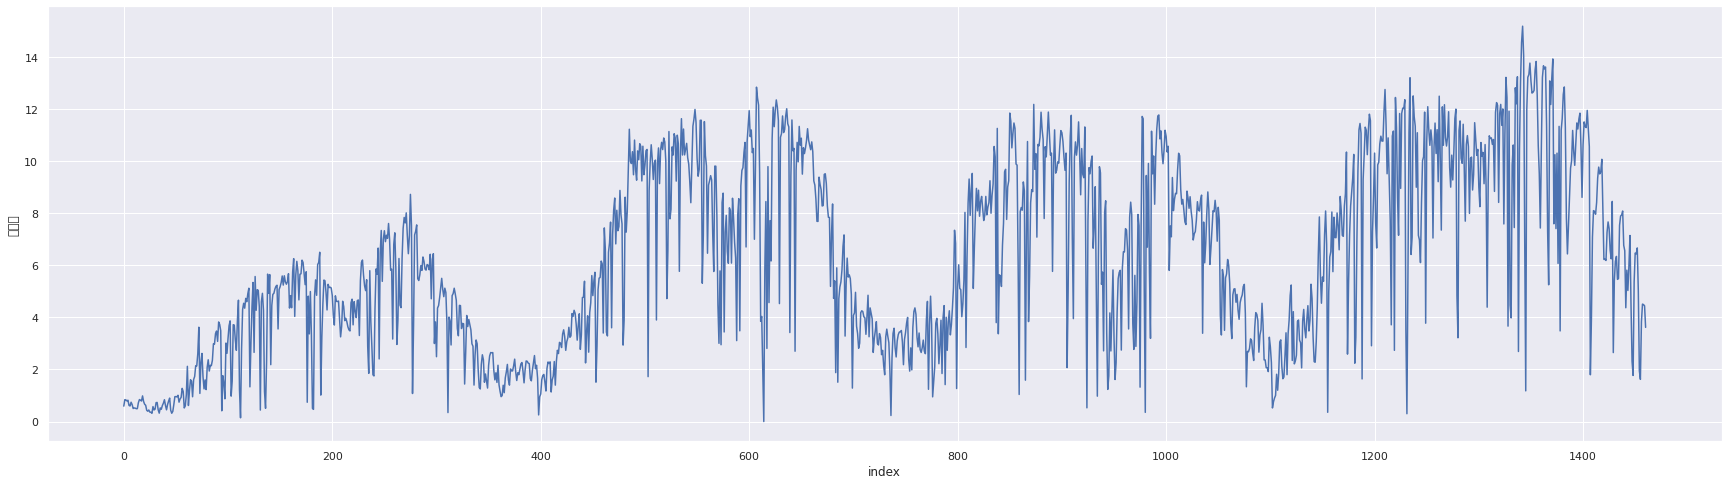

In [458]:
get_view_df(train, 'cycle_광진구')
get_view_df(train, 'unrule_광진구')
get_view_df(train, 'trend_광진구')
get_view_df(train, '광진구')

In [459]:
val_df = train.iloc[1096-CFG['X_RANGE']:].reset_index().drop(columns='index') # 20210101 ~ 20211231
# 위의 1096-CFG['X_RANGE']의 이유는 20210101을 예측하기 위해서는 이전 X_RANGE만큼의 일수가 필요하므로
train_df = train.iloc[:1096].reset_index().drop(columns='index') # 20180101 ~ 20201231

## Data Pre-processing

In [460]:
def get_x_y_data_feature(df, infer=False):
    # x_range : x일전까지의 데이터를 통해 예측
    x_data = []
    y_data = []
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        x_data.append(np.array(df.loc[i-CFG['X_RANGE']:i-1, train_df.columns]).astype(float))
        y_data.append(np.array(df.loc[i, ['cycle_광진구', 'unrule_광진구', 'trend_광진구','cycle_동대문구', 
                                          'unrule_동대문구', 'trend_동대문구', 'cycle_성동구', 'unrule_성동구',
                                    'trend_성동구', 'cycle_중랑구', 'unrule_중랑구', 'trend_중랑구']]).astype(float))
    if infer:
        return x_data
    else:
        return x_data, y_data

In [461]:
def make_ymd_feature_v1(df):
    df['년'] = df['일시'].str[:4].astype(int)/1000.
    df['월'] = df['일시'].str[5:7].astype(int)/12.
    df['일'] = df['일시'].str[8:10].astype(int)/31.
    df = df.drop('일시',axis=1)
    return df

In [462]:
train_df = make_ymd_feature_v1(train_df)
val_df = make_ymd_feature_v1(val_df)

In [463]:
train_x_1, train_y_1 = get_x_y_data_feature(train_df)

  0%|          | 0/1089 [00:00<?, ?it/s]

In [464]:
val_x_1, val_y_1 = get_x_y_data_feature(val_df)

  0%|          | 0/365 [00:00<?, ?it/s]

In [465]:
train_x_1[0].shape, train_y_1[0].shape

((7, 19), (12,))

In [466]:
train_df.head(2)

,광진구,동대문구,성동구,중랑구,cycle_광진구,unrule_광진구,trend_광진구,cycle_동대문구,unrule_동대문구,trend_동대문구,cycle_성동구,unrule_성동구,trend_성동구,cycle_중랑구,unrule_중랑구,trend_중랑구,년,월,일
0,0.592,0.368,0.580,0.162,0.116824,-0.156410,0.734238,0.109717,-0.169174,0.529312,0.136639,-0.277299,0.843289,0.140730,-0.092770,0.246814,2.018,0.083333,0.032258
1,0.840,0.614,1.034,0.260,0.118891,0.100249,0.725328,0.115987,0.082535,0.523153,0.141457,0.185809,0.833688,0.139241,0.009269,0.242859,2.018,0.083333,0.064516


## CustomDataset

In [467]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        else:
            return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

In [468]:
train_dataset_1 = CustomDataset(train_x_1, train_y_1)
train_loader_1 = DataLoader(train_dataset_1, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset_1 = CustomDataset(val_x_1, val_y_1)
val_loader_1 = DataLoader(val_dataset_1, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## Define Model

In [469]:
class BaseModel_feature(nn.Module):
    def __init__(self):
        super(BaseModel_feature, self).__init__()
        self.lstm = nn.LSTM(input_size=19, hidden_size=256, num_layers=1, batch_first=True)
        # input size = 데이터 열 갯수
        
        self.multioutput_reg = nn.Sequential(
            nn.Linear(in_features=256, out_features=128), 
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=12),

            # nn.Linear(in_features=128, out_features=64), 
            # nn.BatchNorm1d(64),
            # nn.ReLU(),

            # nn.Linear(in_features=64, out_features=12),
            # out feature = 예측해야하는 지역 갯수
        )
        
    def forward(self, x):
        hidden, _ = self.lstm(x)
        output = self.multioutput_reg(hidden[:,-1,:])
        return output

## Train

In [470]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.L1Loss().to(device)
    
    best_loss = 9999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for X, Y in iter(train_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            optimizer.zero_grad()
            
            output = model(X)
            loss = criterion(output, Y)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        val_mae = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{_train_loss:.5f}] Val MAE : [{val_mae:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_mae)
            
        if best_loss > val_mae:
            best_loss = val_mae
            best_model = model 
    return best_model

In [471]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for X, Y in iter(val_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            output = model(X)
            
            loss = criterion(output, Y)
            
            val_loss.append(loss.item())
    
    _val_loss = np.mean(val_loss)
    return _val_loss    

## Run!!

In [472]:
model_feature = BaseModel_feature()

In [473]:
optimizer = torch.optim.Adam(params = model_feature.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4,threshold_mode='abs',min_lr=1e-8, verbose=True)
best_model = train(model_feature, optimizer, train_loader_1, val_loader_1, scheduler, device) # 2018.01.01 ~ 2020.12.31 까지 데이터로 학습

Epoch : [1] Train Loss : [1.16425] Val MAE : [1.49864]
Epoch : [2] Train Loss : [0.56792] Val MAE : [3.50957]
Epoch : [3] Train Loss : [0.53365] Val MAE : [2.46223]
Epoch : [4] Train Loss : [0.51908] Val MAE : [1.78622]
Epoch : [5] Train Loss : [0.49955] Val MAE : [1.22741]
Epoch : [6] Train Loss : [0.46408] Val MAE : [0.86220]
Epoch : [7] Train Loss : [0.42364] Val MAE : [0.75083]
Epoch     7: reducing learning rate of group 0 to 5.0000e-03.
Epoch : [8] Train Loss : [0.42361] Val MAE : [0.66716]
Epoch : [9] Train Loss : [0.40690] Val MAE : [0.65640]
Epoch : [10] Train Loss : [0.42872] Val MAE : [0.74639]
Epoch : [11] Train Loss : [0.39019] Val MAE : [0.63598]
Epoch : [12] Train Loss : [0.38809] Val MAE : [0.67628]
Epoch    12: reducing learning rate of group 0 to 2.5000e-03.
Epoch : [13] Train Loss : [0.39411] Val MAE : [0.66432]
Epoch : [14] Train Loss : [0.38186] Val MAE : [0.62639]
Epoch : [15] Train Loss : [0.39626] Val MAE : [0.71114]
Epoch : [16] Train Loss : [0.40454] Val MAE :

## Inference

In [474]:
def make_ymd_feature(df):
    df['일시'] = df['일시'].astype(str)
    df['년'] = df['일시'].str[:4].astype(int)/1000.
    df['월'] = df['일시'].str[4:6].astype(int)/12.
    df['일'] = df['일시'].str[6:8].astype(int)/31.
    df = df[['년', '월', '일', '광진구', '동대문구', '성동구', '중랑구']]
    return df

In [475]:
test_df = pd.read_csv('./sample_submission.csv')
test_df = make_ymd_feature(test_df)
test_df = pd.concat([val_df[CFG['X_RANGE']*(-1):], test_df]).reset_index().drop(columns='index')
test_df.fillna(0, inplace=True)

In [476]:
def inference(model, df, device):
    model.to(device)
    model.eval()
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        X = torch.Tensor(np.array(df.loc[i-CFG['X_RANGE']:i-1, train_df.columns]).astype(float)).unsqueeze(0)
        X = X.to(device)
        with torch.no_grad():
            model_pred = model(X)[0]
        
        model_pred = model_pred.cpu().numpy()
        df.loc[i, ['cycle_광진구', 'unrule_광진구', 'trend_광진구','cycle_동대문구', 
                                          'unrule_동대문구', 'trend_동대문구', 'cycle_성동구', 'unrule_성동구',
                                    'trend_성동구', 'cycle_중랑구', 'unrule_중랑구', 'trend_중랑구']] = model_pred
                                    
    return df.loc[CFG['X_RANGE']:, ['cycle_광진구', 'unrule_광진구', 'trend_광진구','cycle_동대문구', 
                                          'unrule_동대문구', 'trend_동대문구', 'cycle_성동구', 'unrule_성동구',
                                    'trend_성동구', 'cycle_중랑구', 'unrule_중랑구', 'trend_중랑구']].reset_index().drop(columns=['index'])

In [477]:
preds = inference(best_model, test_df, device)

  0%|          | 0/334 [00:00<?, ?it/s]

In [478]:
def get_x_y_data(df, infer=False):
    # x_range : x일전까지의 데이터를 통해 예측
    x_data = []
    y_data = []
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        x_data.append(np.array(df.loc[i-CFG['X_RANGE']:i-1, train_df.columns]).astype(float))
        y_data.append(np.array(df.loc[i, ['광진구', '동대문구', '성동구', '중랑구']]).astype(float))
    if infer:
        return x_data
    else:
        return x_data, y_data

In [479]:
train_x, train_y = get_x_y_data(train_df)
val_x, val_y = get_x_y_data(val_df)

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

In [480]:
train_x[0].shape, train_y[0].shape

((7, 19), (4,))

In [481]:
train_dataset = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_x, val_y)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [482]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = nn.LSTM(input_size=19, hidden_size=256, num_layers=4, batch_first=True)
        # input size = 데이터 열 갯수, num layer = ???
        
        self.multioutput_reg = nn.Sequential(
            nn.Linear(in_features=256, out_features=128), 
            nn.BatchNorm1d(128),
            nn.ReLU(),
                        
            nn.Linear(in_features=128, out_features=64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            
            nn.Linear(in_features=64, out_features=32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            nn.Linear(in_features=32, out_features=16),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Linear(in_features=16, out_features=4),
            # out feature = 예측해야하는 지역 갯수
        )
        
    def forward(self, x):
        hidden, _ = self.lstm(x)
        output = self.multioutput_reg(hidden[:,-1,:])
        return output

In [483]:
model = BaseModel()

In [484]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4,threshold_mode='abs',min_lr=1e-8, verbose=True)
best_model = train(model, optimizer, train_loader, val_loader, scheduler, device) # 2018.01.01 ~ 2020.12.31 까지 데이터로 학습

Epoch : [1] Train Loss : [3.87431] Val MAE : [6.38472]
Epoch : [2] Train Loss : [3.25584] Val MAE : [5.70897]
Epoch : [3] Train Loss : [2.48641] Val MAE : [3.53489]
Epoch : [4] Train Loss : [1.74789] Val MAE : [4.37729]
Epoch : [5] Train Loss : [1.17630] Val MAE : [1.70969]
Epoch : [6] Train Loss : [1.01167] Val MAE : [2.58780]
Epoch     6: reducing learning rate of group 0 to 5.0000e-03.
Epoch : [7] Train Loss : [0.96336] Val MAE : [2.09730]
Epoch : [8] Train Loss : [0.92488] Val MAE : [1.90974]
Epoch : [9] Train Loss : [0.90884] Val MAE : [1.57510]
Epoch : [10] Train Loss : [0.86992] Val MAE : [1.90985]
Epoch : [11] Train Loss : [1.09039] Val MAE : [1.69465]
Epoch    11: reducing learning rate of group 0 to 2.5000e-03.
Epoch : [12] Train Loss : [1.05553] Val MAE : [1.66802]
Epoch : [13] Train Loss : [0.92717] Val MAE : [1.65415]
Epoch : [14] Train Loss : [0.86067] Val MAE : [1.68968]
Epoch : [15] Train Loss : [0.87577] Val MAE : [1.66064]
Epoch : [16] Train Loss : [0.83888] Val MAE :

In [485]:
def inference(model, df, device):
    model.to(device)
    model.eval()
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        X = torch.Tensor(np.array(df.loc[i-CFG['X_RANGE']:i-1, train_df.columns]).astype(float)).unsqueeze(0)
        X = X.to(device)
        with torch.no_grad():
            model_pred = model(X)[0]
        
        model_pred = model_pred.cpu().numpy()
        df.loc[i, ['광진구', '동대문구', '성동구', '중랑구']] = model_pred
    return df.loc[CFG['X_RANGE']:, ['광진구', '동대문구', '성동구', '중랑구']].reset_index().drop(columns=['index'])

In [486]:
preds = inference(best_model, test_df, device)

  0%|          | 0/334 [00:00<?, ?it/s]

In [487]:
preds.max(), preds.min() ,  preds.mean() 

(광진구     12.450417
 동대문구     7.967440
 성동구     10.373364
 중랑구      6.272512
 dtype: float64, 광진구     2.365263
 동대문구    1.343881
 성동구     1.764624
 중랑구     0.848313
 dtype: float64, 광진구     11.524253
 동대문구     7.352058
 성동구      9.601960
 중랑구      5.760805
 dtype: float64)

In [448]:
best_sub = pd.read_csv('submit_v4_2.6.csv').set_index('일시')
best_sub.max(), best_sub.min(), best_sub.mean()

(광진구     10.958
 동대문구     7.018
 성동구      9.070
 중랑구      5.541
 dtype: float64, 광진구     2.151
 동대문구    1.280
 성동구     1.788
 중랑구     0.855
 dtype: float64, 광진구     8.245871
 동대문구    5.110539
 성동구     6.820644
 중랑구     3.938093
 dtype: float64)

In [449]:
best_sub1 = pd.read_csv('submit_v6_2.8.csv').set_index('일시')
best_sub1.max(), best_sub1.min()

(광진구     11.850
 동대문구     7.748
 성동구      9.671
 중랑구      6.353
 dtype: float64, 광진구     2.244
 동대문구    1.318
 성동구     1.852
 중랑구     0.878
 dtype: float64)

In [182]:
gap_sub1 = pd.read_csv('submit_v5_4.8.csv').set_index('일시')
gap_sub1.max(), gap_sub1.min()

(광진구     4.684
 동대문구    2.777
 성동구     4.063
 중랑구     1.992
 dtype: float64, 광진구     1.982
 동대문구    1.207
 성동구     1.608
 중랑구     0.796
 dtype: float64)

## Submission

In [488]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,일시,광진구,동대문구,성동구,중랑구
0,20220101,0,0,0,0
1,20220102,0,0,0,0
2,20220103,0,0,0,0
3,20220104,0,0,0,0
4,20220105,0,0,0,0


In [489]:
submit['광진구'] = preds['광진구'].round(3)
submit['동대문구'] = preds['동대문구'].round(3)
submit['성동구'] = preds['성동구'].round(3)
submit['중랑구'] = preds['중랑구'].round(3)

In [490]:
submit.to_csv('./submit.csv', index=False)

In [ ]:
# train
train_df

In [ ]:
val_df

In [ ]:
# 예측 대상
test_df.loc[CFG['X_RANGE']:,].reset_index(drop=True)